# Singular Spectrum Analysis for Prices Forecasting 

Data extracted from:

"Sistema de Abastecimiento y Precios" - MINAG
http://sistemas.minag.gob.pe/sisap/portal2/mayorista/#herramientasMenu

Analysis for the products with the most significant prices variances during 2017 (jan-aug)

Source: Portal Nacional de Datos Abiertos
http://www.datosabiertos.gob.pe/search/field_topic/prosperidad-económica-29?query=precios+por+productos+variedad+&sort_by=changed&sort_order=DESC

- Limón cítrico (Lemon)
- Ají Amarillo (Chili pepper)
- Ajo (Garlic)
- Zapallo Loche (Pumpkin)

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import sys
from numpy import matrix as m
from pandas import DataFrame as df
from scipy import linalg

#nb_dir = "/home/upadmin/Project/singular_spectrum_analysis/method/SSA.py"
#sys.path.append(nb_dir)

#path = "/home/upadmin/Project/singular_spectrum_analysis/data/"
ts = pd.read_csv('/Users/gabriela/Documents/datamining/zapallo2016.csv',
                     names=['Fecha', 'Precio'],
                     parse_dates=True, index_col='Fecha')
try:
    import seaborn
except:
    pass
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 11, 4

In [2]:
#SSA DEFINITION

class SSA(object):
    '''Singular Spectrum Analysis object'''
    def __init__(self, time_series):
        self.ts = pd.DataFrame(time_series)
        self.ts_name = self.ts.columns.tolist()[0]
        if self.ts_name == 0:
            self.ts_name = 'ts'
        self.ts_v = self.ts.values
        self.ts_N = self.ts.shape[0]
        self.freq = self.ts.index.inferred_freq

    @staticmethod
    def _printer(name, *args):
        '''Helper function to print messages neatly'''
        print('-' * 40)
        print(name + ':')
        for msg in args:
            print(msg)

    @staticmethod
    def _dot(x, y):
        '''Alternative formulation of dot product to allow missing values in arrays/matrices'''
        pass

    @staticmethod
    def get_contributions(X=None, s=None, plot=True):
        '''Calculate the relative contribution of each of the singular values'''
        lambdas = np.power(s, 2)
        frob_norm = np.linalg.norm(X)
        ret = df(lambdas / (frob_norm ** 2), columns=['Contribution'])
        ret['Contribution'] = ret.Contribution.round(4)
        if plot:
            ax = ret[ret.Contribution != 0].plot.bar(legend=False)
            ax.set_xlabel("Lambda_i")
            ax.set_title('Non-zero contributions of Lambda_i')
            vals = ax.get_yticks()
            ax.set_yticklabels(['{:3.2f}%'.format(x * 100) for x in vals])
            return ax
        return ret[ret.Contribution > 0]

    @staticmethod
    def diagonal_averaging(hankel_matrix):
        '''Performs anti-diagonal averaging from given hankel matrix
        Returns: Pandas DataFrame object containing the reconstructed series'''
        mat = m(hankel_matrix)
        L, K = mat.shape
        L_star, K_star = min(L, K), max(L, K)
        new = np.zeros((L, K))
        if L > K:
            mat = mat.T
        ret = []

        # Diagonal Averaging
        for k in range(1 - K_star, L_star):
            mask = np.eye(K_star, k=k, dtype='bool')[::-1][:L_star, :]
            mask_n = sum(sum(mask))
            ma = np.ma.masked_array(mat.A, mask=1 - mask)
            ret += [ma.sum() / mask_n]

        return df(ret).rename(columns={0: 'Reconstruction'})

    def view_time_series(self):
        '''Plot the time series'''
        self.ts.plot(title='Original Time Series')

    def embed(self, embedding_dimension=None, suspected_frequency=None, verbose=False, return_df=False):
        '''Embed the time series with embedding_dimension window size.
        Optional: suspected_frequency changes embedding_dimension such that it is divisible by suspected frequency'''
        if not embedding_dimension:
            self.embedding_dimension = self.ts_N // 2
        else:
            self.embedding_dimension = embedding_dimension
        if suspected_frequency:
            self.suspected_frequency = suspected_frequency
            self.embedding_dimension = (self.embedding_dimension // self.suspected_frequency) * self.suspected_frequency

        self.K = self.ts_N - self.embedding_dimension + 1
        self.X = m(linalg.hankel(self.ts, np.zeros(self.embedding_dimension))).T[:, :self.K]
        self.X_df = df(self.X)
        self.X_complete = self.X_df.dropna(axis=1)
        self.X_com = m(self.X_complete.values)
        self.X_missing = self.X_df.drop(self.X_complete.columns, axis=1)
        self.X_miss = m(self.X_missing.values)
        self.trajectory_dimentions = self.X_df.shape
        self.complete_dimensions = self.X_complete.shape
        self.missing_dimensions = self.X_missing.shape
        self.no_missing = self.missing_dimensions[1] == 0

        if verbose:
            msg1 = 'Embedding dimension\t:  {}\nTrajectory dimensions\t: {}'
            msg2 = 'Complete dimension\t: {}\nMissing dimension     \t: {}'
            msg1 = msg1.format(self.embedding_dimension, self.trajectory_dimentions)
            msg2 = msg2.format(self.complete_dimensions, self.missing_dimensions)
            self._printer('EMBEDDING SUMMARY', msg1, msg2)

        if return_df:
            return self.X_df

    def decompose(self, verbose=False):
        '''Perform the Singular Value Decomposition and identify the rank of the embedding subspace
        Characteristic of projection: the proportion of variance captured in the subspace'''
        X = self.X_com
        self.S = X * X.T
        self.U, self.s, self.V = linalg.svd(self.S)
        self.U, self.s, self.V = m(self.U), np.sqrt(self.s), m(self.V)
        self.d = np.linalg.matrix_rank(X)
        Vs, Xs, Ys, Zs = {}, {}, {}, {}
        for i in range(self.d):
            Zs[i] = self.s[i] * self.V[:, i]
            Vs[i] = X.T * (self.U[:, i] / self.s[i])
            Ys[i] = self.s[i] * self.U[:, i]
            Xs[i] = Ys[i] * (m(Vs[i]).T)
        self.Vs, self.Xs = Vs, Xs
        self.s_contributions = self.get_contributions(X, self.s, False)
        self.r = len(self.s_contributions[self.s_contributions > 0])
        self.r_characteristic = round((self.s[:self.r] ** 2).sum() / (self.s ** 2).sum(), 4)
        self.orthonormal_base = {i: self.U[:, i] for i in range(self.r)}

        if verbose:
            msg1 = 'Rank of trajectory\t\t: {}\nDimension of projection space\t: {}'
            msg1 = msg1.format(self.d, self.r)
            msg2 = 'Characteristic of projection\t: {}'.format(self.r_characteristic)
            self._printer('DECOMPOSITION SUMMARY', msg1, msg2)

    def view_s_contributions(self, adjust_scale=False, cumulative=False, return_df=False):
        '''
        View the contribution to variance of each singular value and its corresponding signal
        '''
        contribs = self.s_contributions.copy()
        contribs = contribs[contribs.Contribution != 0]
        if cumulative:
            contribs['Contribution'] = contribs.Contribution.cumsum()
        if adjust_scale:
            contribs = (1 / contribs).max() * 1.1 - (1 / contribs)
        ax = contribs.plot.bar(legend=False)
        ax.set_xlabel("Singular_i")
        ax.set_title('Non-zero{} contribution of Singular_i {}'. \
                     format(' cumulative' if cumulative else '', '(scaled)' if adjust_scale else ''))
        if adjust_scale:
            ax.axes.get_yaxis().set_visible(False)
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in vals])
        if return_df:
            return contribs

    @classmethod
    
    def view_reconstruction(cls, *hankel, names=None, return_df=False, plot=True, symmetric_plots=False):
        '''Visualise the reconstruction of the hankel matrix/matrices passed to *hankel'''
        hankel_mat = None
        for han in hankel:
            if isinstance(hankel_mat, m):
                hankel_mat = hankel_mat + han
            else:
                hankel_mat = han.copy()
        hankel_full = cls.diagonal_averaging(hankel_mat)
        title = 'Reconstruction of signal'
        if names or names == 0:
            title += ' associated with singular value{}: {}'
            title = title.format('' if len(str(names)) == 1 else 's', names)
        if plot:
            ax = hankel_full.plot(legend=False, title=title)
            if symmetric_plots:
                velocity = hankel_full.abs().max()[0]
                ax.set_ylim(bottom=-velocity, top=velocity)
        if return_df:
            return hankel_full

    def _forecast_prep(self, singular_values=None):
        self.X_com_hat = np.zeros(self.complete_dimensions)
        self.verticality_coefficient = 0
        self.forecast_orthonormal_base = {}
        if singular_values:
            try:
                for i in singular_values:
                    self.forecast_orthonormal_base[i] = self.orthonormal_base[i]
            except:
                if singular_values == 0:
                    self.forecast_orthonormal_base[0] = self.orthonormal_base[0]
                else:
                    raise ('Please pass in a list/array of singular value indices to use for forecast')
        else:
            self.forecast_orthonormal_base = self.orthonormal_base
        self.R = np.zeros(self.forecast_orthonormal_base[0].shape)[:-1]
        for Pi in self.forecast_orthonormal_base.values():
            self.X_com_hat += Pi * Pi.T * self.X_com
            pi = np.ravel(Pi)[-1]
            self.verticality_coefficient += pi ** 2
            self.R += pi * Pi[:-1]
        self.R = m(self.R / (1 - self.verticality_coefficient))
        self.X_com_tilde = self.diagonal_averaging(self.X_com_hat)

    def forecast_recurrent(self, steps_ahead=12, singular_values=None, plot=False, return_df=False, **plotargs):
        '''Forecast from last point of original time series up to steps_ahead using recurrent methodology
        This method also fills any missing data from the original time series.'''
        try:
            self.X_com_hat
        except(AttributeError):
            self._forecast_prep(singular_values)
        self.ts_forecast = np.array(self.ts_v[0])
        for i in range(1, self.ts_N + steps_ahead):
            try:
                if np.isnan(self.ts_v[i]):
                    x = self.R.T * m(self.ts_forecast[max(0, i - self.R.shape[0]): i]).T
                    self.ts_forecast = np.append(self.ts_forecast, x[0])
                else:
                    self.ts_forecast = np.append(self.ts_forecast, self.ts_v[i])
            except(IndexError):
                x = self.R.T * m(self.ts_forecast[i - self.R.shape[0]: i]).T
                self.ts_forecast = np.append(self.ts_forecast, x[0])
        self.forecast_N = i + 1
        new_index = pd.date_range(start=self.ts.index.min(), periods=self.forecast_N, freq=self.freq)


        forecast_df = df(self.ts_forecast, columns=['Forecast'], index=new_index)
        forecast_df['Original'] = np.append(self.ts_v, [np.nan] * steps_ahead)
        if plot:
            forecast_df.plot(title='Forecasted vs. original time series', **plotargs)
        if return_df:
            return forecast_df

In [3]:
#from SSA import SSA
ssa = SSA(ts)

In [4]:
#SSAforecast(ts,352,120)

In [5]:
print(len(ts)) # 144
K = 352
suspected_seasonality = None 
ssa.embed(embedding_dimension=40, suspected_frequency=suspected_seasonality, verbose=True)

366
----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  40
Trajectory dimensions	: (40, 327)
Complete dimension	: (40, 327)
Missing dimension     	: (40, 0)


In [6]:
ssa.decompose(verbose=True)

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 40
Dimension of projection space	: 38
Characteristic of projection	: 0.9999


In [7]:
ssa.ts_N

366

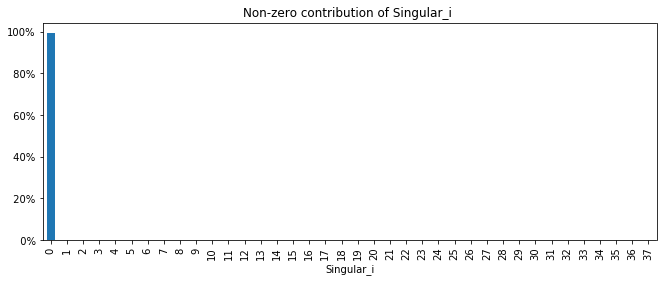

In [8]:
%matplotlib inline 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4

ssa.view_s_contributions()

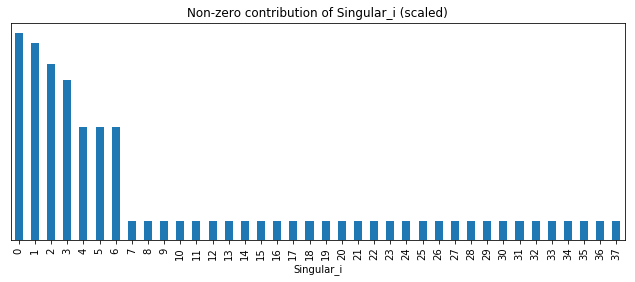

In [9]:
ssa.view_s_contributions(adjust_scale=True)

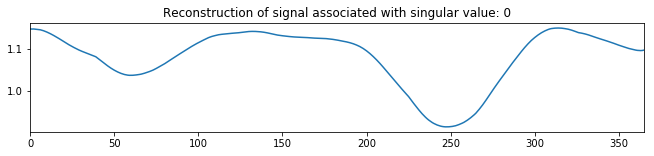

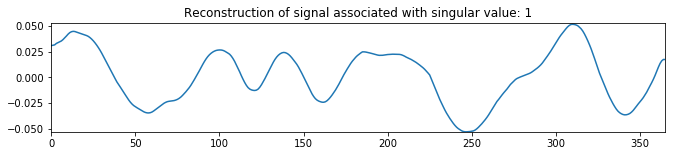

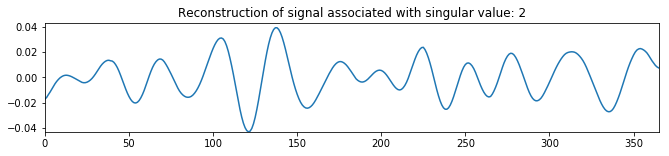

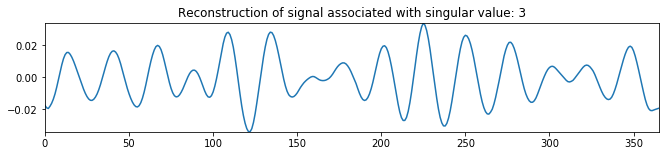

In [10]:
rcParams['figure.figsize'] = 11, 2
for i in range(4):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
#rcParams['figure.figsize'] = 11, 4

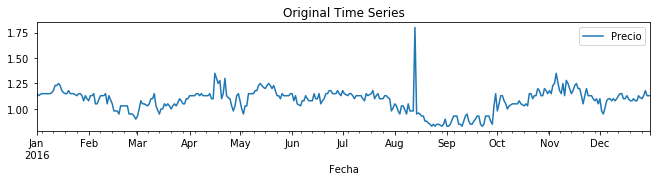

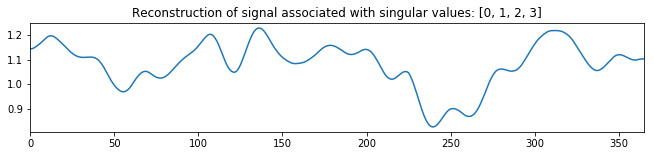

In [11]:
ssa.ts.plot(title='Original Time Series'); # This is the original series for comparison
streams5 = [i for i in range(4)]
reconstructed5 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams5], names=streams5, return_df=True)

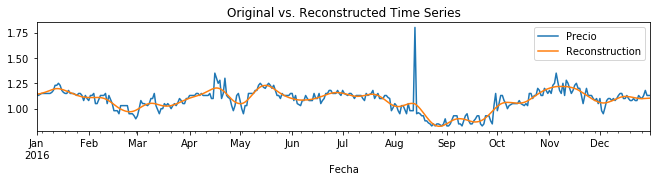

In [12]:
ts_copy5 = ssa.ts.copy()
ts_copy5['Reconstruction'] = reconstructed5.Reconstruction.values
ts_copy5.plot(title='Original vs. Reconstructed Time Series');

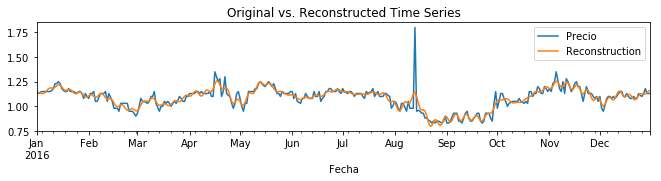

In [13]:
streams10 = [i for i in range(8)]
reconstructed10 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams10], 
                                          names=streams10, return_df=True, plot=False)
ts_copy10 = ssa.ts.copy()
ts_copy10['Reconstruction'] = reconstructed10.Reconstruction.values
ts_copy10.plot(title='Original vs. Reconstructed Time Series');

In [14]:
#HOW MANY STEPS AHEAD RETURNS THE FORECAST 

time_window=100

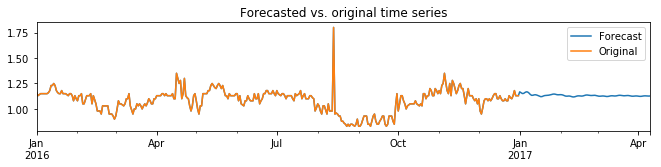

In [15]:
ssa.forecast_recurrent(steps_ahead=time_window, singular_values=streams10, plot=True)

In [16]:
forecast2017 = ssa.forecast_recurrent(steps_ahead=time_window, singular_values=streams10,
                       return_df=True)
forecast = forecast2017.Forecast.tail(time_window).values


In [17]:
ts2 = pd.read_csv('/Users/gabriela/Documents/datamining/zapallo2017.csv',
                     names=['Fecha', 'Precio'],
                     parse_dates=True, index_col='Fecha')
original = ts2.Precio.head(time_window).values

# Forecast vs. Original 

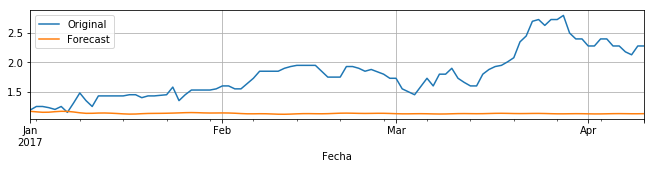

In [18]:
ax = ts2.head(time_window).plot(legend=True)
ax = forecast2017.Forecast.tail(time_window).plot(legend=True)
ax.legend(['Original','Forecast'])
#plt.fill_between(ts2.head(90).values, forecast2017.Forecast.tail(90).values, color='grey', alpha='0.5')
ax.grid()
plt.show()

In [19]:
#forecast2017.Forecast.tail(time_window).to_csv('zapallo17_forecast.csv')

In [20]:
#ts2.head(time_window).to_csv('zapallo17_original.csv')

In [21]:
#ts2.head(time_window).max()

Precio    2.8
dtype: float64

# Kullback Leibler Divergence
    
    Parameters
    ----------
    pk : sequence
        Defines the (discrete) distribution. ``pk[i]`` is the (possibly
        unnormalized) probability of event ``i``.
    qk : sequence, optional
        Sequence against which the relative entropy is computed. Should be in
        the same format as `pk`.
    base : float, optional
        The logarithmic base to use, defaults to ``e`` (natural logarithm).
    Returns
    -------
    S : float
        The calculated entropy.

In [22]:
#KULLBACK-LEIBLER DIVERGENCE

def entropy(pk, qk=None, base=None):
    pk = asarray(pk)
    pk = 1.0*pk / np.sum(pk, axis=0)
    if qk is None:
            vec = entr(pk)
    else:
        qk = asarray(qk)
        if len(qk) != len(pk):
            raise ValueError("qk and pk must have same length.")
        qk = 1.0*qk / np.sum(qk, axis=0)
        vec = rel_entr(pk, qk)
    S = np.sum(vec, axis=0)
    if base is not None:
        S /= log(base)
    return S

In [23]:
import scipy as sp
from scipy import stats

pk = forecast 
qk = original

sp.stats.entropy(pk, qk=None, base=None)

4.6051301313470319

# MAPE
Sum of all Errors divided by the sum of Actual (or forecast) 

In [24]:
#MAPE

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) *100 

In [25]:
#MAPE
mean_absolute_percentage_error(original, forecast)

34.009410011035364